In [1]:
# Import all necessary modules
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib
import sklearn.model_selection
%matplotlib inline 
# sagemaker libraries
import boto3
import sagemaker

In [2]:
# Load the data and perform exploratory analysis
df = pd.read_csv('data.csv', header = 0, index_col = 0)

In [3]:
# Scale the data for normalization
from sklearn.preprocessing import MinMaxScaler
scaler  = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df.iloc[:,1:]), columns=df.iloc[:,1:].columns)

In [4]:
dict_category = {'B':0, 'M':1}
target = df.iloc[:,0].apply(lambda x : dict_category[x]) # convert the class into 0-1 Binary and store the target class 
X_train,X_test,Y_train,Y_test = sklearn.model_selection.train_test_split(df_scaled, target,test_size=0.2)

In [5]:
data_dir = '../Capstone Project/data_full/'
if not os.path.exists( data_dir ):
    os.makedirs(data_dir)

In [6]:
# create the training and test data and save locally
test = np.hstack([np.reshape(Y_test.values, (Y_test.shape[0], 1)), X_test.values])
train = np.hstack([np.reshape(Y_train.values, (Y_train.shape[0], 1)), X_train.values])
pd.DataFrame(test).to_csv(os.path.join(data_dir,'test.csv'),header=False,index=False)
pd.DataFrame(train).to_csv(os.path.join(data_dir,'train.csv'),header=False,index=False)

In [8]:
# How many samples in train test??
print(f'We have {X_test.shape[0]} number of test samples in our dataset')
print(f'We have {X_train.shape[0]} number of train samples in our dataset')
print(f'We have {X_train.shape[1]} features')

We have 114 number of test samples in our dataset
We have 455 number of train samples in our dataset
We have 30 features


In [9]:
from sagemaker import get_execution_role
session =sagemaker.Session()
# store the current SageMaker session
# get IAM role
role=get_execution_role()
print(role)

bucket_name=session.default_bucket()

arn:aws:iam::172268057478:role/service-role/AmazonSageMaker-ExecutionRole-20210122T150167


In [10]:
# set prefix, a descriptive name for a directory for our train test data
data_dir = '../Capstone Project/data_full/'
prefix = 'cancer-class'
# upload all data to S3
test_location = session.upload_data(os.path.join(data_dir,'test.csv'),key_prefix=prefix)
train_location= session.upload_data(os.path.join(data_dir,'train.csv'),key_prefix=prefix)

In [11]:
from sagemaker.pytorch import PyTorch

# Create an estimtor
# your import and estimator code, here
output_path = 's3://{}/{}'.format(bucket_name, prefix)
estimator = PyTorch(entry_point="train.py", 
                    source_dir="source_pytorch", 
                    role=role,
                    framework_version='1.0',
                    py_version = 'py3',
                    sagemaker_session = session,
                    output_path = output_path,
                    train_instance_count=1, 
                    train_instance_type='ml.p2.xlarge',
                    hyperparameters= {'input_features':30,
                                      'hidden_dim':6, 
                                      'output_dim':1,
                                      'epochs':70
                                     }
                   )

train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [12]:
%time

# Train your estimator on S3 training data
s3_input_train = sagemaker.TrainingInput(s3_data = train_location, content_type='csv')
estimator.fit({'train':s3_input_train})

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 8.34 µs
2021-03-17 21:25:37 Starting - Starting the training job...
2021-03-17 21:26:01 Starting - Launching requested ML instancesProfilerReport-1616016337: InProgress
.........
2021-03-17 21:27:21 Starting - Preparing the instances for training............
2021-03-17 21:29:30 Downloading - Downloading input data
2021-03-17 21:29:30 Training - Downloading the training image.....bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2021-03-17 21:30:20,047 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2021-03-17 21:30:20,078 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2021-03-17 21:30:20,304 sagemaker_pytorch_container.training INFO     Invoking user training script.
2021-03-17 21:30:20,610 sagemaker-containers INFO     Module train does not provide a setup.py. 
Generating setup.py
2021-0

In [13]:
# deploy your model to create a predictor
%time
predictor = estimator.deploy(initial_instance_count=1,instance_type='ml.m4.xlarge')

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 7.63 µs
-----------------!

In [14]:
# read in test data, assuming it is stored locally
test_data = pd.read_csv(os.path.join(data_dir, "test.csv"), header=None, names=None)
# labels are in the first column
test_y = test_data.iloc[:,0]
test_x = test_data.iloc[:,1:]

In [15]:
test_y_preds = predictor.predict(test_x.values.astype(np.float32))
test_y_preds = [round(num) for num in test_y_preds.squeeze()]

In [16]:
from sklearn.metrics import accuracy_score
train_data = pd.read_csv(os.path.join(data_dir, "train.csv"), header=None, names=None)
train_y = train_data.iloc[:,0]
train_x = train_data.iloc[:,1:]
train_y_preds = predictor.predict(train_x.values.astype(np.float32))
train_y_preds = [round(num) for num in train_y_preds.squeeze()]
accuracy = accuracy_score(train_y, train_y_preds)
print("Training accuracy %4.2f" % (100*accuracy), "%" )

Training accuracy 98.68 %


In [17]:
# Second: calculate the test accuracy
accuracy = accuracy_score(test_y, test_y_preds)

print("Test accuracy %4.2f %%" % (100*accuracy) )

Test accuracy 98.25 %


In [37]:
preds_train = np.reshape([train_y], (train_y.shape[0],1))
train       = np.reshape([train_y_preds], (train_y.shape[0],1) )
preds_test  = np.reshape([test_y], (test_y.shape[0],1))
test        = np.reshape([test_y_preds], (test_y.shape[0],1) )
pd.DataFrame(data = np.hstack((train, preds_train)),
             columns = ['original', 'model_output']).to_csv('modeloutput_train.csv')
pd.DataFrame(data = np.hstack((test, preds_test)),
             columns = ['original', 'model_output']).to_csv('modeloutput_test.csv')

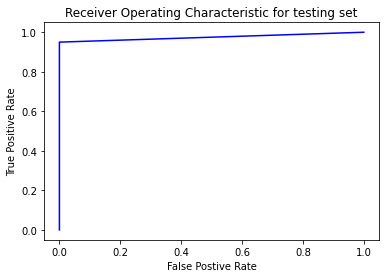

In [48]:
# Plot roc curve for testing set
import sklearn.metrics as metrics
fp, tp, threshold = metrics.roc_curve(test_y, test_y_preds)
roc = metrics.auc(fp, tp)

plt.title('Receiver Operating Characteristic for testing set')
plt.xlabel('False Postive Rate')
plt.ylabel('True Positive Rate')
plt.plot(fp, tp, 'b')


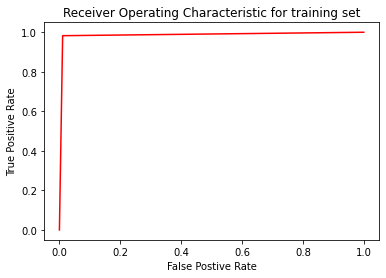

In [49]:

# Plot roc curve for training set
fp, tp, threshold = metrics.roc_curve(train_y, train_y_preds)
roc = metrics.auc(fp, tp)

plt.title('Receiver Operating Characteristic for training set')
plt.xlabel('False Postive Rate')
plt.ylabel('True Positive Rate')
plt.plot(fp, tp, 'r')

In [45]:
from sklearn.metrics import confusion_matrix
confusion_matrix(np.vstack([test, train]), np.vstack([preds_test, preds_train]))

array([[354,   5],
       [  3, 207]])